In [60]:
import torch 
import os
import torch.nn as nn
import seaborn
import koreanize_matplotlib
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from bareunpy import Tagger
from konlpy.tag import Mecab

# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = 'cpu'

In [61]:
import string

PUNCTUATION = string.punctuation
PUNCTUATION

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
ROOT = './DATA/TABLES/'

tables = []
names = os.listdir(ROOT)
for x in names: tables.append(pd.read_csv(ROOT+x, encoding='utf-8'))



In [63]:
for idx, table in enumerate(tables):
    tables[idx] = table.melt().reindex(columns=['value', 'variable'])
    tables[idx].reset_index(drop=True, inplace=True)


In [64]:
names


['경상도.csv', '강원도.csv', '전라도.csv', '충청도.csv', '제주도.csv']

In [65]:
# 제주도로 설정하기
TABLETARGET = tables[-1]

In [66]:
TABLETARGET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101998 entries, 0 to 101997
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   value     101998 non-null  object
 1   variable  101998 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [67]:
TABLETARGET.drop_duplicates(inplace=True)

In [68]:
TABLETARGET.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39605 entries, 0 to 101997
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   value     39605 non-null  object
 1   variable  39605 non-null  object
dtypes: object(2)
memory usage: 928.2+ KB


In [69]:
# zip_tables = list(zip(tables, names))

class TableDataset(Dataset):
    
    def __init__(self, table):
        super().__init__()
        self.table = table
        self.category = self.table['variable'].astype('category')
        self.label = self.category.cat.codes
        self.catlabel = pd.concat([self.category, self.label], axis=1)
        # print(type(self.label), type(self.table), self.label.shape, self.table.shape)
        
    def __len__(self):
        number = len(self.table)
        return number
    
    def __getitem__(self, idx):
        # 데이터 로드
        label = self.label.iloc[idx]
        sentence = self.table['value'].iloc[idx]
        
        return label, sentence
        
# 토큰화 함수
from jamo import h2j, j2hcj
def tokenize(iterator, tokenizer):
    for label, text in iterator:
        yield tokenizer(text)

def tokenize_baerun(iterator, tokenizer):
    for label, text in iterator:
        yield tokenizer.tags('안녕하세요').morphs()

In [70]:
train = TABLETARGET.sample(frac=0.8)
test = TABLETARGET.drop(train.index)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train.dropna(inplace=True)
test.dropna(inplace=True)


train['variable'].value_counts(), test['variable'].value_counts()

(사투리    16957
 표준어    14727
 Name: variable, dtype: int64,
 사투리    4264
 표준어    3657
 Name: variable, dtype: int64)

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   value     31684 non-null  object
 1   variable  31684 non-null  object
dtypes: object(2)
memory usage: 495.2+ KB


In [72]:

# 데이터셋 정의
gyd_train = TableDataset(train)
gyd_test = TableDataset(test)
gyd_total = TableDataset(TABLETARGET)


gyd_test[0]

(0, '독 잡을 때 막 떼분 물을 지치민 독털 잘 뽑아지메')

In [73]:
train.shape, gyd_train.__len__(), test.shape

((31684, 2), 31684, (7921, 2))

In [74]:
UNK = '<unk>'
PAD = '<pad>'

# 토큰화 인스턴스 생성 
with open('./hangul_stopword.txt') as f:
    stopwords = f.read().splitlines()

def tokenizer(x):
    result = Mecab().morphs(x)
    for idx, word in enumerate(result):
        for char in word:
            if char in PUNCTUATION:
                result[idx] = result[idx].replace(char, '')
                # print('punc_deleted')
        # if word in stopwords:
        #     result.pop(idx)
            # print('stop_deleted',idx)
    return result


API_KEY = 'koba-TXPHP7A-AOWEX4Y-WCTFG3I-RFAISLA'
tokenizer_baerun = Tagger(API_KEY, '127.0.0.1', 5757)


# tokenizer_baerun = tokenizer_baerun.tags('안녕하세요').morphs()
# tokenizer_baerun

In [75]:
import pickle
VOCAFILE = './vocab_jeju.pkl'
if not os.path.exists(VOCAFILE):
    # 단어사전 생성하기 
    vocab = build_vocab_from_iterator(tokenize(gyd_train, tokenizer), specials=[UNK, PAD], special_first=True)
    # vocab = build_vocab_from_iterator(tokenize_baerun(gyd_train, tokenizer_baerun), specials=[UNK, PAD])

    # default unk
    vocab.set_default_index(vocab[UNK])
    with open(VOCAFILE, 'wb') as f:
        pickle.dump(vocab, f)
else:
    with open(VOCAFILE, 'rb') as f:
        vocab = pickle.load(f)



In [76]:
dir(vocab.vocab)

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append_token',
 'default_index_',
 'get_default_index',
 'get_itos',
 'get_stoi',
 'insert_token',
 'itos_',
 'lookup_indices',
 'lookup_token',
 'lookup_tokens',
 'set_default_index']

In [77]:
vocab(['먹', '것'])

[20, 41]

In [78]:
vocab(['먹', '것', '이', '것'])

[20, 41, 4, 41]

In [79]:
def text_pipeline(x):
    return vocab(tokenizer(x))

# def label_pipeline(x):
#     # 데이터셋에서 라벨을 0부터 잡았으므로 그대로 정수 반환
#     return int(x)

def collate_batch(batch):
    labels, text_list, offsets = [], [], [0]
    
    for label, text in batch:
        
        labels.append(label)
        
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)
        
        offsets.append(processed_text.size(0))
        
        
    labels = torch.tensor(labels, dtype=torch.int64).to(DEVICE)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0).to(DEVICE)
    text_list = torch.cat(text_list).to(DEVICE)
    
    return labels, text_list, offsets


In [80]:
BATCHSIZE = 10000


trainloader = DataLoader(gyd_train, batch_size=BATCHSIZE, collate_fn=collate_batch, num_workers=64)
testloader = DataLoader(gyd_test, batch_size=BATCHSIZE, collate_fn=collate_batch, num_workers=64)


In [81]:
num_Class = len(gyd_train.category.cat.categories)
vocab_size = len(vocab)
embed_dim = 15
hidden_dim = 30

In [82]:
class TextStdDia(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_Class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.sigmoid = nn.Sigmoid()
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        output, _hidden = self.rnn(embedded)
        return self.sigmoid(self.fc(output))


num_Class = len(gyd_train.category.cat.categories)
vocab_size = len(vocab)
embed_dim = 15
hidden_dim = 30

model = TextStdDia(vocab_size, embed_dim, hidden_dim, num_Class).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)




In [83]:
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryConfusionMatrix
import numpy as np

def train(model, iterator, optimizer, criterion, scheduler):
    model.train()
    lossagg = []
    f1 = BinaryF1Score().to(DEVICE)
    cm = BinaryConfusionMatrix().to(DEVICE)
    
    
    for label, text, offsets in iterator:
        label = label.unsqueeze(1).float()

        predictions = model(text, offsets)
        loss = criterion(predictions, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lossagg.append(loss.item())
        f1(predictions, label)
        cm(predictions, label)
    
    print(f"Train F1 score : {f1.compute()}")
    print(f"Train Confusion Matrix : \n{cm.compute()}")

    return f1.compute().cpu().item(), np.mean(lossagg)
    
def evaluate(model, iterator, criterion):
    model.eval()
    lossagg = []
    f1 = BinaryF1Score().to(DEVICE)
    cm = BinaryConfusionMatrix().to(DEVICE)
    
    
    with torch.no_grad():
        for label, text, offsets in iterator:
            label = label.unsqueeze(1).float()
            
            predictions = model(text, offsets)
            loss = criterion(predictions, label)
            
            lossagg.append(loss.item())
            f1(predictions, label)
            cm(predictions, label)
            
    print(f"Test F1 score : {f1.compute()}")
    print(f"Test Confusion Matrix : \n{cm.compute()}")
    
    return f1.compute().cpu().item(), np.mean(lossagg), cm.compute().cpu().numpy()


### 병목 증상 설명

- 기존 이미지의 경우에는 GPU에서 돌리는 것이 효과적
- 하지만 단어 태깅이 CPU 에서 이루어지므로 자연어 처리에서는 CPU가 더 효과적임


In [84]:
EPOCHES = 30
results = [[], []]
latestcm = None
for epoch in range(EPOCHES):
    print(f"Epoch {epoch+1} 학습 및 평가 결과")
    tresult, trainloss = train(model, trainloader, optimizer, criterion, scheduler)
    evalresult, val_loss, latestcm = evaluate(model, testloader, criterion)
    
    results[0].append(tresult)
    results[1].append(evalresult)
    
    scheduler.step(val_loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'Early stopping at epoch {epoch}')
        break


    




Epoch 1 학습 및 평가 결과
Train F1 score : 0.6173864603042603
Train Confusion Matrix : 
tensor([[ 1879, 15078],
        [ 1418, 13309]])
Test F1 score : 0.002729257568717003
Test Confusion Matrix : 
tensor([[4262,    2],
        [3652,    5]])
Epoch 2 학습 및 평가 결과
Train F1 score : 0.0017633095849305391
Train Confusion Matrix : 
tensor([[16952,     5],
        [14714,    13]])
Test F1 score : 0.0
Test Confusion Matrix : 
tensor([[4264,    0],
        [3657,    0]])
Epoch 3 학습 및 평가 결과
Train F1 score : 0.0
Train Confusion Matrix : 
tensor([[16957,     0],
        [14727,     0]])
Test F1 score : 0.0
Test Confusion Matrix : 
tensor([[4264,    0],
        [3657,    0]])
Epoch 4 학습 및 평가 결과
Train F1 score : 0.0
Train Confusion Matrix : 
tensor([[16957,     0],
        [14727,     0]])
Test F1 score : 0.0
Test Confusion Matrix : 
tensor([[4264,    0],
        [3657,    0]])
Epoch 5 학습 및 평가 결과
Train F1 score : 0.0
Train Confusion Matrix : 
tensor([[16957,     0],
        [14727,     0]])
Test F1 score :

In [85]:
torch.save(model, './model_jeju_nodelete.pt')

In [86]:
latestcm / latestcm.sum(axis = 1)

array([[0.84193246, 0.18430407],
       [0.05511257, 0.93573968]])

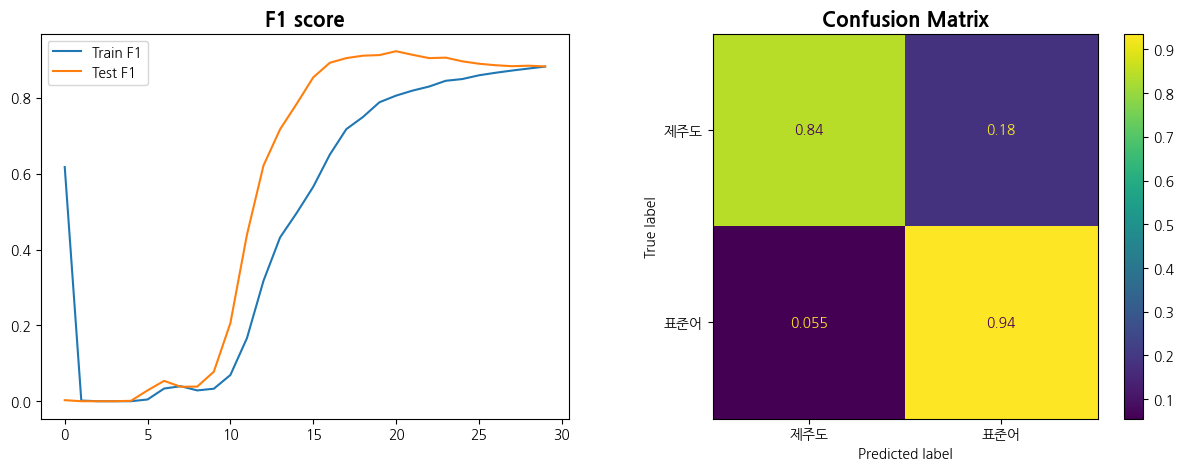

In [87]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.metrics import ConfusionMatrixDisplay

fig, axe = plt.subplots(1, 2, figsize=(15, 5))


titlearg = {
    'fontsize' : 15,
    'fontweight' : 'bold',

}
plt.axes(axe[0])
plt.title('F1 score', **titlearg)
plt.plot(results[0], label='Train F1')
plt.plot(results[1], label='Test F1')
plt.legend()
plt.axes(axe[1])
plt.title('Confusion Matrix', **titlearg)
ConfusionMatrixDisplay(latestcm / latestcm.sum(axis = 1), display_labels=['제주도', '표준어']).plot(ax= axe[1])
plt.show()


In [48]:
# !pip install bareunpy

In [89]:
stdsentence = '''
레옹 베르트에게 이 책을 바친다.
이 책을 어른에게 바친 데 대해 어린이들에게 용서를 바란다. 나에게는 그럴 만한 중요한 이유가 있다. 그것은 무엇보다도 그 사람은 이 세상에서 나와 가장 친한 친구이기 때문이라는 점이다. 그리고 그는 무엇이든지 알아들을 수 있으며 어린이들을 위한 책까지도 다 이해한다는 점이다. 세 번째 이유는 그가 프랑스에 살고 있는데 그 곳에서 추위와 굶주림에 떨고 있다는 사실이다. 그는 위로받아야 할 처지에 있는 것이다. 그래도 이 모든 이유들이 부족하다면 예전 어린 시절의 그에게 이 책을 바치겠다. 어른들도 모두 한때는 어린이였으니까 말이다. 그래서 바치는 글을 이렇게 고쳐 쓴다.
'어린이였을 때의 레옹 베르트에게 이 책을 바친다.'
'''
dialectsentence = '''
이건 나신디는 요 시상에서 젤로 아름답고 젤로 실픈 풍경이우다. 이건 앞에 이신 페이지의 풍경과 똑고튼 풍경이주만, 요라분덜신디는 자세히 배리게 해주젠 허난 또시 혼 번 그린 그림이우다. 이곳은 왕자가 지구에 나타났당 사라진 곳이우다.

만일에 요라분덜이 언젠가 아프리카의 소막을 여행하게 될 따문, 이곳을 틀림없이 기억해 낼 수 있도록 이 풍경을 주의 깊게 뵈려줘시민 햄수다. 경허고 만일에 요라분덜이 이곳을 지나가게 되민 부디 와리지말앙 그 벨 바로 밑에서 호끔만 기달려 줘시민 허염수다! 만일 그 때 혼 호끌락헌 아이가 요라분 조껕띠 다가왔거들랑, 가이가 웃고 이시멍, 거의 머리자락이 금발머리라민, 경허고 곧는 말에 대답을 하지 안허민, 요라분덜은 가이가 누게인지 분명히 알아차리게 될 거우다. 경허민 요라분덜은 이추룩 슬퍼허고 이신 나를 외면허지 말앙, 나신디 친절허게 대허영 줘시민 햄수다! 경허고 부디 나신디 편지로 소식을 전해 줘시민 좋쿠다. 가
'''

std = model(torch.tensor(vocab(tokenizer(stdsentence))), torch.tensor([0]))
dialect = model(torch.tensor(vocab(tokenizer(dialectsentence))), torch.tensor([0]))

nn.Sigmoid()(std)
print(f"std : {std.item()}, dialect : {dialect.item()}")
print(f'std : {stdsentence}, dialect : {dialectsentence}')



std : 0.6343405246734619, dialect : 0.34216123819351196
std : 
레옹 베르트에게 이 책을 바친다.
이 책을 어른에게 바친 데 대해 어린이들에게 용서를 바란다. 나에게는 그럴 만한 중요한 이유가 있다. 그것은 무엇보다도 그 사람은 이 세상에서 나와 가장 친한 친구이기 때문이라는 점이다. 그리고 그는 무엇이든지 알아들을 수 있으며 어린이들을 위한 책까지도 다 이해한다는 점이다. 세 번째 이유는 그가 프랑스에 살고 있는데 그 곳에서 추위와 굶주림에 떨고 있다는 사실이다. 그는 위로받아야 할 처지에 있는 것이다. 그래도 이 모든 이유들이 부족하다면 예전 어린 시절의 그에게 이 책을 바치겠다. 어른들도 모두 한때는 어린이였으니까 말이다. 그래서 바치는 글을 이렇게 고쳐 쓴다.
'어린이였을 때의 레옹 베르트에게 이 책을 바친다.'
, dialect : 
이건 나신디는 요 시상에서 젤로 아름답고 젤로 실픈 풍경이우다. 이건 앞에 이신 페이지의 풍경과 똑고튼 풍경이주만, 요라분덜신디는 자세히 배리게 해주젠 허난 또시 혼 번 그린 그림이우다. 이곳은 왕자가 지구에 나타났당 사라진 곳이우다.

만일에 요라분덜이 언젠가 아프리카의 소막을 여행하게 될 따문, 이곳을 틀림없이 기억해 낼 수 있도록 이 풍경을 주의 깊게 뵈려줘시민 햄수다. 경허고 만일에 요라분덜이 이곳을 지나가게 되민 부디 와리지말앙 그 벨 바로 밑에서 호끔만 기달려 줘시민 허염수다! 만일 그 때 혼 호끌락헌 아이가 요라분 조껕띠 다가왔거들랑, 가이가 웃고 이시멍, 거의 머리자락이 금발머리라민, 경허고 곧는 말에 대답을 하지 안허민, 요라분덜은 가이가 누게인지 분명히 알아차리게 될 거우다. 경허민 요라분덜은 이추룩 슬퍼허고 이신 나를 외면허지 말앙, 나신디 친절허게 대허영 줘시민 햄수다! 경허고 부디 나신디 편지로 소식을 전해 줘시민 좋쿠다. 가

